In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model/config.json
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model/tokenizer.json
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model/tokenizer_config.json
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model/model.safetensors
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model/special_tokens_map.json
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model/vocab.txt
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/ternary_model/config.json
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/ternary_model/tokenizer.json
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/ternary_model/tokenizer_config.json
/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/ternary_model/model.safetensors
/kaggle/input/distilbert-uncased-fin

### READY THIS PLEASE BCZ IT IS HELPFUL TO WORK WITH THIS BASELINE

##### HELLO TEAM!! :)  

I have tried a little to come up with this base line for the map-charting-student-math-misunderstanding competitoin that we are participating in.

This notebook contain data loading, model loading and fine tuning ( This parts are commented in this notebook), model inference on test dataset and submision file saving.

NOTE: 

1. It is possible that you can perform **RUN ALL CELLS** and see what the three models do on the test dataset, but the main target I just shared this notebook is for us to help each other to perform **data cleaning** (e.f removing stopwords) as they are not included in the notebook and perform **better model fine-tuning** as the given models (ternary,binary and misconception) in distilbert-uncased-fine-tuned are fine-tuned on one epoch and with no parameter tuning concerned. Then we will be able to perform well

2. Another thing is to note that the **notebook contains three models** that perform different task with the next model being fed on the results of another, so pay attention on cell running and make **sure that the previous model has a very high accuracy** as the results of one affect the other.

3. **Reading the first comments in each notebook** if available because they are more helpful

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset



2025-09-04 18:52:04.633236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757011924.869963      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757011924.939485      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import random
import os

def set_seed(seed: int = 42):
    """
    Set seed for reproducibility across Python, NumPy, and PyTorch.
    Ensures deterministic behavior where possible.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # Deterministic settings for PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seed(SEED)

# Optional: confirm
print("Seed set to:", SEED)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))


Seed set to: 42
CUDA available: False


In [4]:

train = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv')
train = pd.DataFrame(train)

In [5]:
train.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Category Misconception
0,0.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN,True_Correct- NA
1,1.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN,True_Correct- NA


In [6]:
train['Misconception'].unique()

array([nan, 'Incomplete', 'WNB', 'SwapDividend', 'Mult', 'FlipChange',
       'Irrelevant', 'Wrong_Fraction', 'Additive', 'Not_variable',
       'Adding_terms', 'Inverse_operation', 'Inversion', 'Duplication',
       'Wrong_Operation', 'Whole_numbers_larger', 'Longer_is_bigger',
       'Ignores_zeroes', 'Shorter_is_bigger', 'Wrong_fraction',
       'Adding_across', 'Denominator-only_change',
       'Incorrect_equivalent_fraction_addition', 'Division',
       'Subtraction', 'Unknowable', 'Definition', 'Interior', 'Positive',
       'Tacking', 'Wrong_term', 'Firstterm', 'Base_rate',
       'Multiplying_by_4', 'Certainty', 'Scale'], dtype=object)

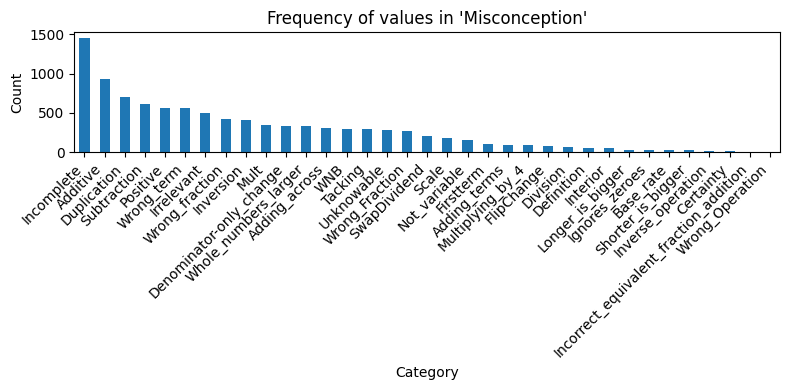

In [7]:
# containace of the misconception

import pandas as pd
import matplotlib.pyplot as plt

object_cols = ['Misconception']

for col in object_cols:
    plt.figure(figsize=(8,4))
    train[col].value_counts().plot(kind="bar")
    plt.title(f"Frequency of values in '{col}'")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [8]:
# we will firstly fine tune a bnary classification model on questionText and  MC_answer 
# to predict weathr it is tre or false
# then we will train another model on questiontext, MC-answer, and studentExplanation to predict
# 3 classes misconception, correct, neither (or 0,1,2 then we will map this)
# Again we train a model for multi classification of the Misconceptions, the model will be fine tuned on
# questionText, MC_answer, (weather correct, neither or miconception), (weather true or false), studentExplanation

# Finall we will join all the predictions according to the submition format e.g True_Neither- NA


In [9]:
train.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Category Misconception
0,0.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN,True_Correct- NA
1,1.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN,True_Correct- NA


In [10]:
test = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')
test.head(2)

,row_id,QuestionId,QuestionText,QuestionText.1,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,i think this answer is because 3 triangles are...


In [11]:
submission = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/submission.csv')
submission.head(2)

,row_id,Category Misconception
0,36696,True_Correct- NA True_Neither- NA False_Neithe...
1,36697,False_Misconception- Incomplete True_Correct- ...


In [12]:
# Un comment this for fine-tuning binary_model but if you just firstly need to inference on
# binary_model given to see what it gives on test dataset don't uncomment


'''
# Load CSV
train = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv")

# Labels
train["binary_label"] = train["Category"].apply(lambda x: 1 if str(x).split("_")[0].lower() == "true" else 0)

# Dataset
texts = ("Question is " + train["QuestionText"].astype(str) + "Student answer is " + train["MC_Answer"].astype(str)).tolist()
labels = train["binary_label"].tolist()
dataset = Dataset.from_dict({"text": texts, "label": labels})

# Tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=128), batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Train/val split
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./binary_model",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    disable_tqdm=False,
    report_to="none"  # avoids trying to log to WandB/other
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
)

# Train
trainer.train()

# After trainer.train()
model.save_pretrained("./binary_model_final")
tokenizer.save_pretrained("./binary_model_final")

# Check CUDA
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))
'''

'\n# Load CSV\ntrain = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv")\n\n# Labels\ntrain["binary_label"] = train["Category"].apply(lambda x: 1 if str(x).split("_")[0].lower() == "true" else 0)\n\n# Dataset\ntexts = ("Question is " + train["QuestionText"].astype(str) + "Student answer is " + train["MC_Answer"].astype(str)).tolist()\nlabels = train["binary_label"].tolist()\ndataset = Dataset.from_dict({"text": texts, "label": labels})\n\n# Tokenizer\nMODEL_NAME = "distilbert-base-uncased"\ntokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)\ndataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=128), batched=True)\ndataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])\n\n# Train/val split\ndataset = dataset.train_test_split(test_size=0.2, seed=42)\n\n# Model\nmodel = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)\n\n# Training arguments\n

In [13]:
# here we are performimg inference on the binary_model

# Paths
MODEL_NAME = "distilbert-base-uncased"
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/binary_model"  # same as output_dir used in training
TEST_CSV = "/kaggle/input/map-charting-student-math-misunderstandings/test.csv"

# Load test data
test_df = pd.read_csv(TEST_CSV)

# Prepare text
texts = ("Question is " + test_df["QuestionText"].astype(str) + " Student answer is " + test_df["StudentExplanation"].astype(str)).tolist()

# Load tokenizer and model
tokenizer_binary = AutoTokenizer.from_pretrained(MODEL_DIR)
model_binary = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model_binary.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_binary.to(device)
binary_model = model_binary

# Tokenize
encodings = tokenizer_binary(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)
import torch
from tqdm import tqdm

batch_size = 32  # reduce if still OOM
binary_preds = []

binary_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
binary_model.to(device)

# Move encodings to CPU temporarily if needed
input_ids_all = encodings["input_ids"]
attention_mask_all = encodings["attention_mask"]

for i in tqdm(range(0, len(input_ids_all), batch_size)):
    batch_input_ids = input_ids_all[i:i+batch_size].to(device)
    batch_attention_mask = attention_mask_all[i:i+batch_size].to(device)

    with torch.no_grad():
        outputs = binary_model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        binary_preds.extend(batch_preds)

# Add predictions to dataframe
test_df["binary_pred"] = binary_preds
print(test_df[["QuestionText", "StudentExplanation", "binary_pred"]].head())


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

                                        QuestionText  \
0  What fraction of the shape is not shaded? Give...   
1  What fraction of the shape is not shaded? Give...   
2                      Which number is the greatest?   

                                  StudentExplanation  binary_pred  
0  I think that 1/3 is the answer, as it's the si...            0  
1  i think this answer is because 3 triangles are...            0  
2     because the 2 makes it higher than the others.            0  


In [14]:
test_df['binary_pred'].nunique()

1

In [15]:
# once you have performed fine-tuning of the binary model un comment this for 
# creating the dataset for ternary_model if you are also to fine-tune it

'''
def ternary_mapper(x):
    # Take the last part after splitting by "_"
    last_part = str(x).split("_")[-1].lower()
    
    if last_part == "correct":
        return 1
    elif last_part == "neither":
        return 2
    elif last_part == "misconception":
        return 0
    else:
        return -1

# Apply to the column
train["ternary_label"] = train["Category"].apply(ternary_mapper)

'''

'\ndef ternary_mapper(x):\n    # Take the last part after splitting by "_"\n    last_part = str(x).split("_")[-1].lower()\n    \n    if last_part == "correct":\n        return 1\n    elif last_part == "neither":\n        return 2\n    elif last_part == "misconception":\n        return 0\n    else:\n        return -1\n\n# Apply to the column\ntrain["ternary_label"] = train["Category"].apply(ternary_mapper)\n\n'

In [16]:
train.head(3)

# also uncomment this if you are performimg fine tuning else don't (if you are just inferencing don't uncomment)
# because it might rise some errors

'''
train_valid = train[train["ternary_label"].isin([0,1,2])].copy()

def make_ternary_dataset(df):
    # Concatenate MC_Answer + StudentExplanation + binary prediction as string
    df["input_text"] = "Question is " + df["QuestionText"].astype(str) + "Student answer is "+df["MC_Answer"].astype(str)+ "Score is (1=True, 0=False)  " + df["binary_pred"].astype(str) + "Student explanation is " + df["StudentExplanation"].astype(str) 
    texts = df["input_text"].tolist()
    labels = df["ternary_label"].tolist()
    return Dataset.from_dict({"text": texts, "label": labels})

ds_ternary = make_ternary_dataset(train_valid)
'''

'\ntrain_valid = train[train["ternary_label"].isin([0,1,2])].copy()\n\ndef make_ternary_dataset(df):\n    # Concatenate MC_Answer + StudentExplanation + binary prediction as string\n    df["input_text"] = "Question is " + df["QuestionText"].astype(str) + "Student answer is "+df["MC_Answer"].astype(str)+ "Score is (1=True, 0=False)  " + df["binary_pred"].astype(str) + "Student explanation is " + df["StudentExplanation"].astype(str) \n    texts = df["input_text"].tolist()\n    labels = df["ternary_label"].tolist()\n    return Dataset.from_dict({"text": texts, "label": labels})\n\nds_ternary = make_ternary_dataset(train_valid)\n'

In [17]:
# uncomment this if you are fine-tuning ternary_model to see if there are unusual labels 
# for the model (if it gives an error youo know that there are unusual labels not in the list)
# make sure that you run the previuos fine-tuning codes correctly

'''

assert all(l in [0,1,2] for l in ds_ternary["label"]), "Invalid labels detected!"
'''

'\n\nassert all(l in [0,1,2] for l in ds_ternary["label"]), "Invalid labels detected!"\n'

we will need to train it on more epochs

In [18]:
# uncomment this if you are going to perform fine-tuning on the ternary_model

'''

# Tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

ds_ternary = ds_ternary.map(tokenize_function, batched=True)
ds_ternary.set_format("torch")
ds_ternary = ds_ternary.train_test_split(test_size=0.2, seed=42)

# ----------------------------
# 6️⃣ Train ternary model
# ----------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
output_dir = "./ternary_model"

training_args = TrainingArguments(
    output_dir="./ternary_model",
    do_eval=True,
    per_device_train_batch_size=16,  # reduce if OOM occurs
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    disable_tqdm=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_ternary['train'],
    eval_dataset=ds_ternary['test'],  # ideally use a real validation split
    tokenizer=tokenizer
)

trainer.train()

    # Save model + tokenizer
model.save_pretrained("./ternary_model_final")
tokenizer.save_pretrained("./ternary_model_final")
    
# ----------------------------
# 9️⃣ Confirm CUDA
# ----------------------------
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))
'''

'\n\n# Tokenize\ndef tokenize_function(examples):\n    return tokenizer(examples["text"], padding="max_length", truncation=True)\n\nds_ternary = ds_ternary.map(tokenize_function, batched=True)\nds_ternary.set_format("torch")\nds_ternary = ds_ternary.train_test_split(test_size=0.2, seed=42)\n\n# ----------------------------\n# 6️⃣ Train ternary model\n# ----------------------------\nmodel = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)\ntokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)\noutput_dir = "./ternary_model"\n\ntraining_args = TrainingArguments(\n    output_dir="./ternary_model",\n    do_eval=True,\n    per_device_train_batch_size=16,  # reduce if OOM occurs\n    per_device_eval_batch_size=16,\n    num_train_epochs=1,\n    weight_decay=0.01,\n    logging_steps=100,\n    save_strategy="no",\n    disable_tqdm=False,\n    report_to="none"\n)\n\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=ds_ternary[\'train\'],

In [19]:
# here we are just inferencing a ternary_model on test datset in the Distilbert-uncased-fine
# -tuned models

# Paths
MODEL_NAME = "distilbert-base-uncased"
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/ternary_model"  # same as output_dir used in training
TEST_CSV = "/kaggle/input/map-charting-student-math-misunderstandings/test.csv"

# Load test data
 # will be changed to test csv for submission

# Prepare text
texts = ("Student explanation is " + test_df["StudentExplanation"].astype(str) + " Score is (1=true, 0=false) " + test_df["binary_pred"].astype(str)).tolist()

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize
encodings = tokenizer(texts, truncation=True, padding="max_length", return_tensors="pt")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)
import torch
from tqdm import tqdm

batch_size = 32  # reduce if still OOM
ternary_preds = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move encodings to CPU temporarily if needed
input_ids_all = encodings["input_ids"]
attention_mask_all = encodings["attention_mask"]

for i in tqdm(range(0, len(input_ids_all), batch_size)):
    batch_input_ids = input_ids_all[i:i+batch_size].to(device)
    batch_attention_mask = attention_mask_all[i:i+batch_size].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        ternary_preds.extend(batch_preds)

# Add predictions to dataframe
test_df["ternary_pred"] = ternary_preds
print(test_df[["StudentExplanation", "binary_pred", "ternary_pred"]].head())


100%|██████████| 1/1 [00:03<00:00,  3.19s/it]

                                  StudentExplanation  binary_pred  \
0  I think that 1/3 is the answer, as it's the si...            0   
1  i think this answer is because 3 triangles are...            0   
2     because the 2 makes it higher than the others.            0   

   ternary_pred  
0             2  
1             2  
2             2  


In [20]:
test_df.head(30)

,row_id,QuestionId,QuestionText,QuestionText.1,StudentExplanation,binary_pred,ternary_pred
0,36696,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,"I think that 1/3 is the answer, as it's the si...",0,2
1,36697,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,i think this answer is because 3 triangles are...,0,2
2,36698,32835,Which number is the greatest?,Which number is the greatest?,because the 2 makes it higher than the others.,0,2


In [21]:
# uncomment this if you are going to perform fine-tuning on the misconception_model
# else live it commented

'''

train['Misconception'] = train['Misconception'].replace('nan', np.nan)

# Get all unique values, including NaN
unique_values = train['Misconception'].unique()

# Create a mapping: NaN -> 0, others -> 1, 2, ...
label_map = {}
label_index = 1  # start from 1 because we want NaN to be 0
for val in unique_values:
    if pd.isna(val):
        label_map[val] = 0
    else:
        label_map[val] = label_index
        label_index += 1

# Apply mapping to create new label column
train['Misconception_label'] = train['Misconception'].map(label_map)

# Optional: check the mapping
print(label_map)
print(train[['Misconception', 'Misconception_label']].head())

'''

"\n\ntrain['Misconception'] = train['Misconception'].replace('nan', np.nan)\n\n# Get all unique values, including NaN\nunique_values = train['Misconception'].unique()\n\n# Create a mapping: NaN -> 0, others -> 1, 2, ...\nlabel_map = {}\nlabel_index = 1  # start from 1 because we want NaN to be 0\nfor val in unique_values:\n    if pd.isna(val):\n        label_map[val] = 0\n    else:\n        label_map[val] = label_index\n        label_index += 1\n\n# Apply mapping to create new label column\ntrain['Misconception_label'] = train['Misconception'].map(label_map)\n\n# Optional: check the mapping\nprint(label_map)\nprint(train[['Misconception', 'Misconception_label']].head())\n\n"

In [22]:
# uncomment this code to perform fine-tuning of misconception_model on the training dataset
# if you just need inference on the given model don't uncomment this codes

'''

def make_misconception_dataset(df):
    # Concatenate MC_Answer + StudentExplanation + binary prediction as string
    df["input_text"] = "Question is " + df["QuestionText"].astype(str) + "Student answer is "+df["MC_Answer"].astype(str)+ "Score is (1=True, 0=False)  " + df["binary_pred"].astype(str) + "Student explanation is " + df["StudentExplanation"].astype(str) + "CATEGORY IS <VERY IMPORTANT> " + df['ternary_pred'].astype(str) +" </VERY IMPORTANT>"
    texts = df["input_text"].tolist()
    labels = df["Misconception_label"].tolist()
    return Dataset.from_dict({"text": texts, "label": labels})

ds_misconception_ = make_misconception_dataset(train)


# Tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

ds_misconception_ = ds_misconception_.map(tokenize_function, batched=True)
ds_misconception_.set_format("torch")
ds_misconception = ds_misconception_.train_test_split(test_size=0.2, seed=42)

# ----------------------------
# 6️⃣ Train ternary model
# ----------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=36)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
output_dir = "./misconception_model"

training_args = TrainingArguments(
    output_dir="./misconception_model",
    do_eval=True,
    per_device_train_batch_size=16,  # reduce if OOM occurs
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    disable_tqdm=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_misconception['train'],
    eval_dataset=ds_misconception['test'],  # ideally use a real validation split
    tokenizer=tokenizer
)

trainer.train()

    # Save model + tokenizer
model.save_pretrained("./misconception_model_final")
tokenizer.save_pretrained("./misconception_model_final")
    
# ----------------------------
# 9️⃣ Confirm CUDA
# ----------------------------
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))
'''

'\n\ndef make_misconception_dataset(df):\n    # Concatenate MC_Answer + StudentExplanation + binary prediction as string\n    df["input_text"] = "Question is " + df["QuestionText"].astype(str) + "Student answer is "+df["MC_Answer"].astype(str)+ "Score is (1=True, 0=False)  " + df["binary_pred"].astype(str) + "Student explanation is " + df["StudentExplanation"].astype(str) + "CATEGORY IS <VERY IMPORTANT> " + df[\'ternary_pred\'].astype(str) +" </VERY IMPORTANT>"\n    texts = df["input_text"].tolist()\n    labels = df["Misconception_label"].tolist()\n    return Dataset.from_dict({"text": texts, "label": labels})\n\nds_misconception_ = make_misconception_dataset(train)\n\n\n# Tokenize\ndef tokenize_function(examples):\n    return tokenizer(examples["text"], padding="max_length", truncation=True)\n\nds_misconception_ = ds_misconception_.map(tokenize_function, batched=True)\nds_misconception_.set_format("torch")\nds_misconception = ds_misconception_.train_test_split(test_size=0.2, seed=42)\

In [23]:
print(model.config.num_labels)


3


In [24]:

# Paths
MODEL_NAME = "distilbert-base-uncased"
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model"  # same as output_dir used in training
TEST_CSV = "/kaggle/input/map-charting-student-math-misunderstandings/test.csv"

# Load test data
test_df  # will be changed to test csv for submission

# Prepare text
texts = ("Question is " + test_df["QuestionText"].astype(str) + "Score is (1=True, 0=False)  " + test_df["binary_pred"].astype(str) + "Student explanation is " + test_df["StudentExplanation"].astype(str) + "CATEGORY IS <VERY IMPORTANT> " + test_df['ternary_pred'].astype(str) +" </VERY IMPORTANT> if very important is not 0 predict/ 0").tolist()

# Load tokenizer and model

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize
encodings = tokenizer(texts, truncation=True, padding="max_length", return_tensors="pt")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)
import torch
from tqdm import tqdm

batch_size = 32  # reduce if still OOM
misconception_preds = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move encodings to CPU temporarily if needed
input_ids_all = encodings["input_ids"]
attention_mask_all = encodings["attention_mask"]

for i in tqdm(range(0, len(input_ids_all), batch_size)):
    batch_input_ids = input_ids_all[i:i+batch_size].to(device)
    batch_attention_mask = attention_mask_all[i:i+batch_size].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        misconception_preds.extend(batch_preds)

# Add predictions to dataframe
test_df["misconception_pred"] = misconception_preds


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


In [25]:
test_df.head()

,row_id,QuestionId,QuestionText,QuestionText.1,StudentExplanation,binary_pred,ternary_pred,misconception_pred
0,36696,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,"I think that 1/3 is the answer, as it's the si...",0,2,2
1,36697,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,i think this answer is because 3 triangles are...,0,2,0
2,36698,32835,Which number is the greatest?,Which number is the greatest?,because the 2 makes it higher than the others.,0,2,0


In [26]:
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/6/misconception_model"  # same as output_dir used in training
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
print(model.config.num_labels)


36


In [27]:
import pandas as pd

# Load your CSV
df = test_df # replace with your path

# 1️⃣ Create decoding dictionaries
binary_map = {0: "False", 1: "True"}
ternary_map = {0: "Misconception", 1: "Correct", 2: "Neither"}
misconception_map = {0: "NA", 1: "scale", 2: "incomplete"}

# 2️⃣ Decode columns
df["binary_decoded"] = df["binary_pred"].map(binary_map)
df["ternary_decoded"] = df["ternary_pred"].map(ternary_map)
df["misconception_decoded"] = df["misconception_pred"].map(misconception_map)

# 3️⃣ Merge into a single feature
df["CategoryMisconception"] = (
    df["binary_decoded"] + "_" + df["ternary_decoded"] + "- " + df["misconception_decoded"]
)

# 4️⃣ Keep only relevant columns for clarity
merged_df = df[["row_id", "CategoryMisconception"]]

# Optional: If you want unique values per QuestionId
# merged_df = merged_df.groupby("QuestionId")["Misconception"].apply(list).reset_index()

print(merged_df.head())


   row_id      CategoryMisconception
0   36696  False_Neither- incomplete
1   36697          False_Neither- NA
2   36698          False_Neither- NA


In [28]:
merged_df.to_csv('submission.csv', index = False)

In [29]:
submission = pd.read_csv('/kaggle/working/submission.csv')
submission

,row_id,CategoryMisconception
0,36696,False_Neither- incomplete
1,36697,False_Neither- NA
2,36698,False_Neither- NA


### REMEMBER TO UPVOTE ANY THING

In [30]:
# sorry that the codes aren't very clean I didn't get enough time

# Also remember that it is possible to make three prediction per sample separated by space

# in the CategoryMisconception column.

# thank you so much for your kind attention